# Task

In IPython notebook (.ipynb) create an function which will apply Gaussian filter on input image. In order for the task to be completely solved, you need to independently implement the 2D convolution of the appropriate filter with an image.


NOTE: *cv2.filter2D() cannot be used, you need to implement the algorithm yourself.*


Display the image in RGB, grayscale image, image histogram and cumulative distribution function (CDF) of image. Explain which image characteristics can be seen on the histogram and CDF. It is necessary to choose the image yourself. The solution has to be explained in the text part of IPython notebook.

# Code

### Base

In [9]:
import numpy as np
import matplotlib.pyplot as plt

imagePath = "image.jpg" # Image path
baseImage = plt.imread(imagePath) # Load image using PLT


### Gaussian Blur

Gaussian blur is one of the most common bluring techniques. Instead of taking an average of each pixel in a n*n square, it takes a weighted average. This weighted average is based on the Gaussian curve, sometimes also called a 'Bell curve' due to a bell-shaped appearance. Considering that we need to convolve over a 2D image, we also must use a 2D filter:

To generate a gaussian filter (kernel), we take in a radius and generate a empty image which with a size of (2r + 1). Once generated, we loop through each pixel individualy and using the gaussian curve formula calculate the curve on both x and y axis. After which the values are multiplied together to form the 2D Gaussian distribution, i.e. filter

Once the filter has been generated, it can be used in a convolution on any image to apply the blur

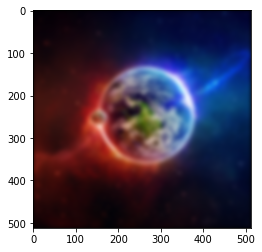

In [10]:
def generateKernel(radius):
    # Generate a image with width = 2 * radius + 1 center pixel
    kernelSize = radius * 2 + 1
    # Store the center pixel index
    middle = radius
    # Sigma coeficient, bell curve width depends from it
    sigma = radius/2

    # Generate an empty image
    kernel = np.zeros(kernelSize * kernelSize).reshape(kernelSize, kernelSize)
    # Loop through each pixel of the kernel
    for x in range(kernelSize):
        for y in range(kernelSize):
            # Calculate bell curve value on the X axis
            a = 1/(np.sqrt(2 * np.pi) * sigma)
            b = np.exp( -( (x-middle)**2 ) / ( 2 * (sigma**2) ) )
            # Calculate bell curve value on the Y axis
            c = 1/(np.sqrt(2 * np.pi) * sigma)
            d = np.exp( -( (y-middle)**2 ) / ( 2 * (sigma**2) ) )
            # Result at (x,y) is equal to the product of the x and y bell curves
            kernel[x, y] = (a*b)*(c*d)
    
    # Return the value of the kernel which is normalized, i.e. in range from 0.0 to 1.0
    return kernel/np.max(kernel)

def gaussianBlur(image, radius):

    # Add padding to our image. This step is necessary due to the nature of this algorithm to shring the image. By adding padding, we increase the image
    # just enough for it to be downsized back to its original size
    paddedImage = np.ones((len(image) + 2*radius, len(image) + 2*radius, 3))
    paddedImage[radius:len(image)+radius, radius:len(image)+radius] = image[:][:]
    # Generate the kernel
    kernel = generateKernel(radius)
    # Get the width of the kernel
    m = kernel.shape[0]
    
    # Get the size of each axis, and downsize x and y axis by the size of the kernel and add one pixel to negate the center pixel
    x = paddedImage.shape[0] - m + 1
    y = paddedImage.shape[1] - m + 1
    z = paddedImage.shape[2]
    # Create a new 3D (image) array where we will store our result
    new_image = np.zeros((x, y, z))
    # Loop through each pixel
    for i in range(x):
        for j in range(y):
            # Convolve each color and store it in the final image. This part effectively multiplies each pixel with the kernel and sums up all the values
            new_image[i,j,0] = np.sum(paddedImage[i:i+m, j:j+m, 0]*kernel)
            new_image[i,j,1] = np.sum(paddedImage[i:i+m, j:j+m, 1]*kernel)
            new_image[i,j,2] = np.sum(paddedImage[i:i+m, j:j+m, 2]*kernel)
    
    # Normalize the image and return it
    new_image /= new_image.max()
    return new_image

blurredImage = gaussianBlur(baseImage, 10)

plt.imshow(blurredImage)

### RGB Image

Display the base image

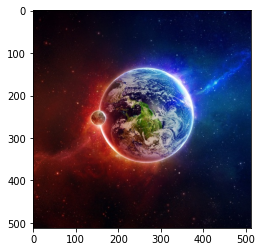

In [11]:
# Show RGB image
plt.imshow(baseImage) 

### Grayscale

There are two methods of converting a image to grayscale: 


Average: G = (R+G+B)/3 or G = R/3 + G/3 + B/3 (each component is divided seperately to prevent uint overflow)


Weighted: G = R * 0.299 + G * 0.587 + B * 0.114


The weighted method is the prefered method due to the nature of the human eye to percieve more green than red and blue colors and it is the one used to dispaly the grayscale image

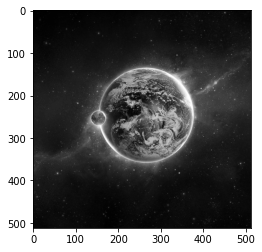

In [12]:
def weightedGrayscale(img):
    return img.dot([0.299, 0.587, 0.114]).astype("uint8")

# Convert the image into grayscale
grayscaleImage = weightedGrayscale(baseImage)

# Display the image
plt.imshow(grayscaleImage, cmap="gray")

### Histogram

Image histograms shows us the count of pixels with the same light intensity. Intensity is represented with values between 0 (unlit pixel) and 255 (fully lit pixel)

We first flatten our image into a 1D array, loop through each element and place it's value in a bucket with other pixels that have the same value. After that, we count the number of pixels in each bin and display it on a graph where the X-Axis is used to represent intensity and the Y-Axis to represent the number of pixels in that specific intensity bucket

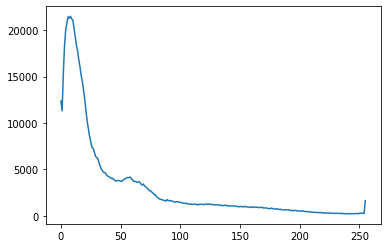

In [13]:
def createHistogram(img):
    flatImage = img.flatten() # convert the image to a 1D array [sizeX * sizeY]
    buckets = np.zeros(256) # create bins, with values from 0 to 255
    for pixel in flatImage: #for each pixel in the image
        buckets[pixel] += 1 # use the pixels value (intensity) as the index for our bucket, and increase the count by one
    return buckets

histogram = createHistogram(baseImage)
plt.plot(histogram) # Display the histogram


The resulting histogram shows us that there are a lot of dark pixels, some mid intensity pixels and a small group of really bright pixels.

If we were only given this histogram, we could guess that the picture is dark with a backlit object. This explains the sudden jump at the end, which representes the rim lighting of the object and a gradual fade into darkness.

After we compare this to our image (grayscale), we can see that the planet is in space (dark background) and has rim lighting. And that there is a gradual fade from light to dark, which can also be observed on the histogram

### CDF

The Cumulative Distribution Function is a graph that represents the probability of a given value X to take a value less than or equal to that point on the curve.

When we read this curve, we read it from right to left as follows:
- We take a intensity: X
- Now we look at the area underneath the curve left of X
- This area shows us the probability of the pixel intensity being less than or equal to X

The further right we go, the greater the probability. The reason behind this is that this is a cumulative function, i.e. the current value is equal to the sum of all the previous values and the value itself.

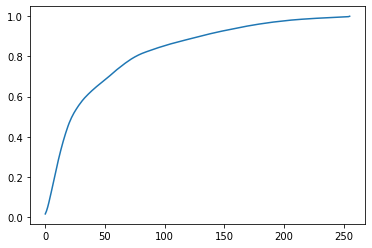

In [14]:
def createCDF(hist):
    # Cumulative sum
    cs = hist.cumsum()
    # Calculate the CDF Curve
    cdf = cs * (hist.max() / cs.max())
    # Return a normalized curve
    return cdf/cdf.max()

cdf = createCDF(histogram)
plt.plot(np.arange(0, 256), cdf) # Display the  CDF

From the above graph, we can say that there is a very high probability that a pixel is less than 255, but a very low probability tahta pixel is less than 10. This does not mean these pixels don't exist, this only means that these pixels are really rare, unless the probability is at 0.0 which means we do not have these pixels on our image